In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm, poisson, nbinom, rv_continuous
from deep_uncertainty.random_variables import DoublePoisson
import matplotlib.pyplot as plt

In [3]:
from deep_uncertainty.evaluation.calibration import compute_continuous_ece

In [4]:
plt.rcParams['figure.dpi'] = 175

## Helper Functions

In [5]:
def plot_posterior_predictive(
    x: np.ndarray,
    y: np.ndarray,
    mu: np.ndarray,
    upper: np.ndarray,
    lower: np.ndarray,
    error_color: str = "r",
    error_alpha: float = 0.2,
    show: bool = True,
    title: str = "",
    ax: plt.Axes | None = None,
):
    """Visualize a model's posterior predictive distribution over a 1d dataset (`x`, `y` both scalars) by showing the expected value and error bounds across the regression targets.

    Args:
        x (np.ndarray): The x values (inputs).
        y (np.ndarray): The ground truth y values (outputs).
        mu (np.ndarray): The expected values of the model's posterior predictive distribution over `y`.
        upper (np.ndarray): Upper bounds for the model's posterior predictive distribution over `y`.
        lower (np.ndarray): Lower bounds for the model's posterior predictive distribution over `y`.
        error_color (str, optional): Color with which to fill the model's error bounds. Defaults to "r".
        alpha (float, optional): Transparency value for the model's error bounds. Defaults to 0.2.
        show (bool, optional): Whether/not to show the resultant plot. Defaults to True.
        title (str, optional): If specified, a title for the resultant plot. Defaults to "".
        ax (plt.Axes | None, optional): If given, the axis on which to plot the posterior predictive distribution. Defaults to None (axis is created).
    """
    order = x.argsort()

    ax = plt.subplots(1, 1, figsize=(10, 6))[1] if ax is None else ax

    ax.scatter(x[order], y[order], alpha=0.1, label="Test Data", s=3)
    ax.plot(x[order], mu[order])
    ax.fill_between(
        x[order], lower[order], upper[order], color=error_color, alpha=error_alpha, label="95% CI"
    )
    ax.set_title(title)
    ax.set_ylim(y.min() - 5, y.max() + 5)
    ax.set_xticks([])
    ax.set_yticks([])
    if show:
        plt.show()

In [6]:
def plot_regression_calibration_curve_cdf(
    y_true: np.ndarray,
    posterior_predictive: rv_continuous,
    num_bins: int = 9,
    ax: plt.Axes | None = None,
    show: bool = True,
):
    """Given targets and a probabilistic regression model (represented as a continuous random variable over the targets), plot a calibration curve.

    Args:
        y_true (ndarray, (n,)): The true values of the regression targets.
        posterior_predictive (rv_continuous): Random variable representing the posterior predictive distribution over the targets.
        num_bins (int): Specifies how many probability thresholds to use for checking CDF calibration. This
                        corresponds to how many points will be plotted to form the calibration curve.
        ax (plt.Axes | None): The axis to plot on (if provided). If None is passed in, an axis is created.
        show (bool): Specifies whether/not to display the resultant plot.
    """
    epsilon = 1e-4
    p_vals = np.linspace(0 + epsilon, 1 - epsilon, num=num_bins).reshape(-1, 1)
    expected_pct_where_cdf_less_than_p = p_vals
    actual_pct_where_cdf_less_than_p = (posterior_predictive.cdf(y_true) <= p_vals).mean(axis=1)

    ece = compute_continuous_ece(y_true, posterior_predictive, num_bins=50, weights="frequency", alpha=2)

    ax = plt.subplots(1, 1)[1] if ax is None else ax
    ax.plot(
        expected_pct_where_cdf_less_than_p,
        expected_pct_where_cdf_less_than_p,
        linestyle="--",
        color="red",
        label="Perfectly calibrated",
    )
    ax.plot(
        expected_pct_where_cdf_less_than_p,
        actual_pct_where_cdf_less_than_p,
        marker="o",
        linestyle="-",
        color="black",
        label="Model",
        markersize=3,
    )
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.annotate(f"ECE: {ece:2f}", xy=(-0.05, 0.9), fontsize=6)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    if show:
        plt.show()

## Data Generation

In [41]:
num_samples = 1000
cont_x = np.random.uniform(1, 10, size=num_samples)
discrete_x = np.random.randint(1, 10, size=num_samples)
gaussian_y = norm.rvs(loc=cont_x, scale=cont_x/4)
poisson_y = poisson.rvs(mu=cont_x)
double_poisson_y = np.array([DoublePoisson(x_i, 3).rvs(1) for x_i in cont_x]).astype(int)
nbinom_y = nbinom.rvs(n=4*discrete_x, p=0.95)

## Produce Figure

In [42]:
mu_hat = cont_x; sigma_hat = cont_x/4
gaussian_post_pred = norm(loc=mu_hat, scale=sigma_hat)

lambda_hat = cont_x
poisson_post_pred = poisson(mu=lambda_hat)

dpo_mu_hat = cont_x
phi_hat = 3
dpo_post_pred = DoublePoisson(dpo_mu_hat, phi_hat)

n_hat = 4*discrete_x
p_hat = 0.95
nbinom_post_pred = nbinom(n=n_hat, p=p_hat)
nbinom_mu_hat = nbinom_post_pred.mean()

/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_98804/1349927967.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


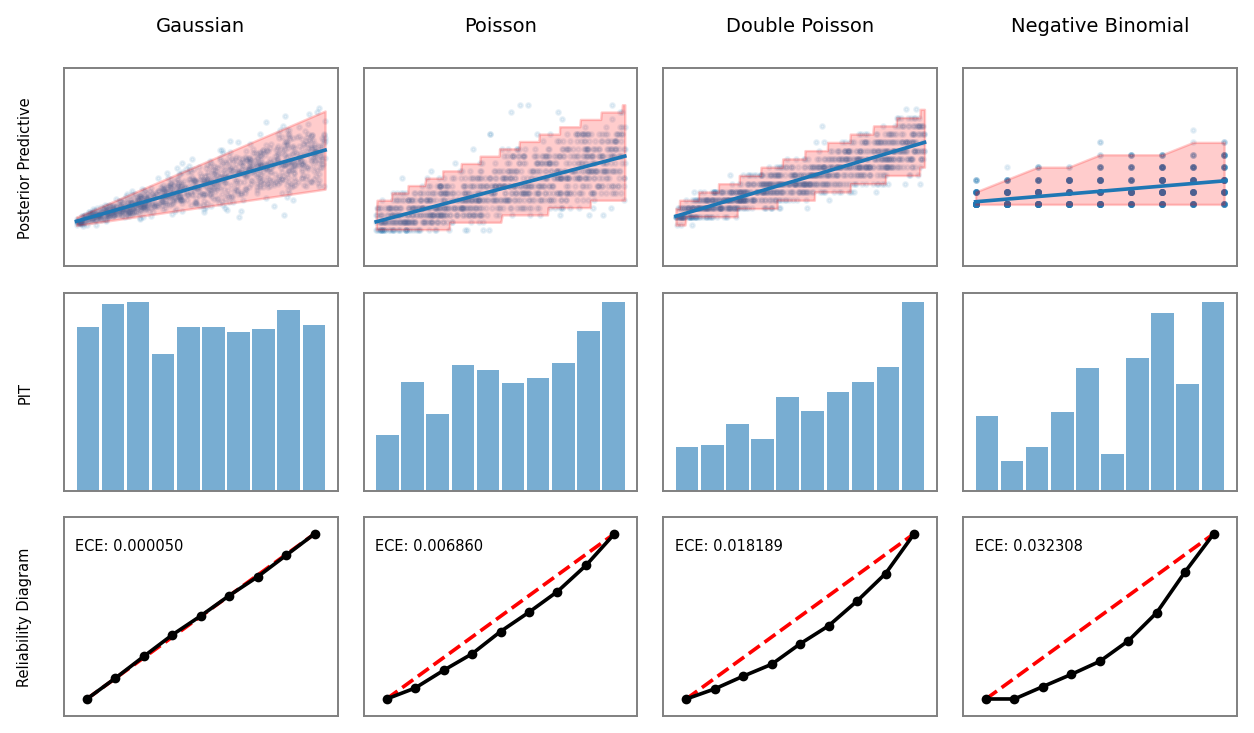

In [49]:
fig, axs = plt.subplots(3, 4, figsize=(7, 4))
title_size = 8
hist_alpha = 0.6
hist_rwidth = 0.9

plot_posterior_predictive(cont_x, gaussian_y, mu_hat, *gaussian_post_pred.ppf([[0.025], [0.975]]), ax=axs[0, 0], show=False)
axs[1, 0].hist(gaussian_post_pred.cdf(gaussian_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])
plot_regression_calibration_curve_cdf(gaussian_y, gaussian_post_pred, ax=axs[2, 0], show=False)

plot_posterior_predictive(cont_x, poisson_y, lambda_hat, *poisson_post_pred.ppf([[0.025], [0.975]]), ax=axs[0, 1], show=False)
axs[1, 1].hist(poisson_post_pred.cdf(poisson_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])
plot_regression_calibration_curve_cdf(poisson_y, poisson_post_pred, ax=axs[2, 1], show=False)

plot_posterior_predictive(cont_x, double_poisson_y, dpo_mu_hat, dpo_post_pred.ppf(0.025), dpo_post_pred.ppf(0.975), ax=axs[0, 2], show=False)
axs[1, 2].hist(dpo_post_pred.cdf(double_poisson_y.reshape(-1, 1).flatten()), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])
plot_regression_calibration_curve_cdf(double_poisson_y.flatten(), dpo_post_pred, ax=axs[2, 2], show=False)

plot_posterior_predictive(discrete_x, nbinom_y, nbinom_mu_hat, nbinom_post_pred.ppf(0.025), nbinom_post_pred.ppf(0.975), ax=axs[0, 3], show=False)
axs[1, 3].hist(nbinom_post_pred.cdf(nbinom_y), density=True, alpha=hist_alpha, rwidth=hist_rwidth)
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])
plot_regression_calibration_curve_cdf(nbinom_y, nbinom_post_pred, ax=axs[2, 3], show=False)

row_labels = ["Posterior Predictive", "PIT", "Reliability Diagram"]
for ax, row in zip(axs[:, 0], row_labels):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=6, ha='right', va='center', rotation=90)
    

col_labels = ["Gaussian", "Poisson", "Double Poisson", "Negative Binomial"]
for ax, col in zip(axs[0, :], col_labels):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 15),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=8, ha='center', va='baseline')
    
for ax in axs.ravel():
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')

plt.show()

In [50]:
fig.tight_layout()
fig.savefig(fname="failure_of_pit.pdf", format="pdf")

/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_98804/3088314453.py:1: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [133]:
fig.savefig(fname="failure_of_pit.png")

### New Discrete ECE?

In [54]:
def compute_discrete_ece(
    targets: np.ndarray,
    probs: np.ndarray,
    k: int,
    bin_strategy: str = "adaptive",
    alpha: float = 1.0,
    num_bins: int = 30,
):
    """Given targets and predictions from a discrete probabilistic regression model (assumed to have support [0, inf)), compute the expected calibration error.

    Suppose we discretize [0, 1] into a set of m bins and assign each target {y_i | 1 <= i <= n} to a bin based on \sum_{j=1}^k P(\\hat{y_{ij}}),
    the cumulative probability of the model's top k predictions for that target. Define acc_k(B) to be the probability, within bin B, that y_i is
    in the top k predictions. Define conf_k(B) to be the average of \sum_{j=1}^k P(\\hat{y_{ij}}) within bin B. Then we have

        ECE = mean([ |acc_k(B) - conf_k(B))|^alpha for B in bins ])

    where alpha controls the severity of the penalty for the magnitude of a given probability residual.

    Bin boundaries can either be selected uniformly across [0, 1] or chosen such that each bin has the same number of targets.

    Args:
        targets (np.ndarray): The regression targets. Shape: (n,)
        probs (np.ndarray): The model's discrete probabilities for each target. Shape: (>=k, n).
        k (int): The number of most likely predictions to use in the calibration evaluation.
        bin_strategy (str, optional): Strategy for choosing bin boundaries. Must be either "uniform" or "adaptive". Defaults to "adaptive" (same # of targets in each bin).
        alpha (int, optional): Controls how severely we penalize the model for the magnitude of a probability residual. Defaults to 1 (error term is |acc(B) - conf(B)|).
        num_bins (int): The number of bins to use. Defaults to 30.

    Returns:
        float: The expected calibration error.
    """
    if probs.shape[0] < k:
        raise ValueError("Must provide probabilities with at least `k` entries for each target.")

    top_k_preds = np.argsort(probs, axis=0)[::-1][:k]
    top_k_probs = probs[top_k_preds, np.arange(len(targets))].sum(axis=0)
    if bin_strategy == "uniform":
        bin_boundaries = np.linspace(0, 1, num=num_bins)
        weights = None
    elif bin_strategy == "adaptive":
        bin_boundaries = pd.qcut(top_k_probs, num_bins, retbins=True, duplicates="drop")[1]
        actual_num_bins = len(bin_boundaries) - 1
        weights = np.ones(actual_num_bins) / actual_num_bins
    else:
        raise ValueError('Invalid bin strategy specified. Must be "uniform" or "adaptive".')

    # Handle if all probabilities are in the same bin.
    if len(bin_boundaries) == 1:
        return np.abs(np.mean([targets[i] in top_k_preds[:, i] for i in range(len(targets))]) - top_k_probs.mean()) ** alpha

    bin_boundaries[-1] += 1e-5  # Make rightmost bin boundary inclusive.
    mask_matrix = (bin_boundaries[:-1, None] <= top_k_probs) & (top_k_probs < bin_boundaries[1:, None])
    bin_counts = mask_matrix.sum(axis=1) + 1e-16
    bin_confidences = np.where(mask_matrix, top_k_probs, 0).sum(axis=1) / bin_counts

    if weights is None:
        weights = 1 / bin_counts

    bin_accuracies = np.where(mask_matrix, np.array([targets[i] in top_k_preds[:, i] for i in range(len(targets))]), 0).sum(axis=1) / bin_counts
    ece = np.dot(weights, np.abs(bin_accuracies - bin_confidences) ** alpha)
    return ece

In [81]:
alpha = 1

In [82]:
probs = poisson_post_pred.pmf(np.arange(poisson_y.min(), poisson_y.max() + 1).reshape(-1, 1))
compute_continuous_ece(poisson_y, poisson_post_pred, num_bins=30, weights="frequency", alpha=alpha), compute_discrete_ece(poisson_y, probs, k=3, alpha=alpha)

(0.07454771805194427, 0.060480738992981106)

In [83]:
probs = nbinom_post_pred.pmf(np.arange(nbinom_y.min(), nbinom_y.max() + 1).reshape(-1, 1))
compute_continuous_ece(nbinom_y, nbinom_post_pred, num_bins=30, weights="frequency", alpha=alpha), compute_discrete_ece(nbinom_y, probs, k=3, alpha=alpha)

(0.1581246509092435, 0.02142127613514211)

In [84]:
probs = dpo_post_pred.pmf(np.arange(double_poisson_y.min(), double_poisson_y.max() + 1).reshape(-1, 1))
compute_continuous_ece(double_poisson_y.flatten(), dpo_post_pred, num_bins=30, weights="frequency", alpha=alpha), compute_discrete_ece(double_poisson_y.flatten(), probs, k=3, alpha=alpha)

(0.12296178674064812, 0.050996748287417924)

## Original Code

In [ ]:
def plot_regression_calibration_curve_interval(
    y_true: np.ndarray,
    posterior_predictive: rv_continuous,
    num_bins: int = 9,
    ax: plt.Axes | None = None,
    show: bool = True,
):
    """Given targets and a probabilistic regression model (represented as a continuous random variable over the targets), plot a calibration curve.

    Args:
        y_true (ndarray, (n,)): The true values of the regression targets.
        posterior_predictive (rv_continuous): Random variable representing the posterior predictive distribution over the targets.
        num_bins (int): Specifies how many probability thresholds to use for checking CDF calibration. This
                        corresponds to how many points will be plotted to form the calibration curve.
        ax (plt.Axes | None): The axis to plot on (if provided). If None is passed in, an axis is created.
        show (bool): Specifies whether/not to display the resultant plot.
    """
    epsilon = 1e-4
    p_vals = np.linspace(0 + epsilon, 1 - epsilon, num=num_bins).reshape(-1, 1)
    expected_pct_in_interval = p_vals
    actual_pct_in_interval = []
    for p in p_vals:
        tail = (1 - p) / 2
        lower, upper = posterior_predictive.ppf(tail), posterior_predictive.ppf(1 - tail)
        in_interval = (y_true >= lower) & (y_true <= upper)
        actual_pct_in_interval.append(in_interval.mean())

    ax = plt.subplots(1, 1)[1] if ax is None else ax
    ax.set_title("Calibration Curve")
    ax.set_xlabel("Expected Confidence Level")
    ax.set_ylabel("Observed Confidence Level")
    ax.plot(
        expected_pct_in_interval,
        expected_pct_in_interval,
        linestyle="--",
        color="red",
        label="Perfectly calibrated",
    )
    ax.plot(
        expected_pct_in_interval,
        actual_pct_in_interval,
        marker="o",
        linestyle="-",
        color="black",
        label="Model",
    )
    ax.legend()
    plt.tight_layout()

    if show:
        plt.show()

/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_65357/768121519.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_65357/1914299827.py:16: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


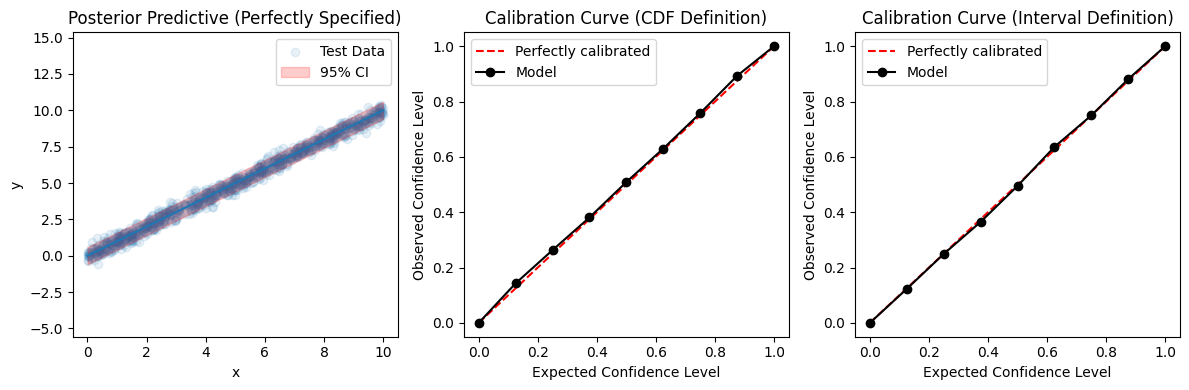

In [7]:
x = np.random.uniform(1e-4, 10, size=1000)
y = norm.rvs(loc=x, scale=0.3)

# Perfectly specified model.
mu_hat = x
sigma_hat = 0.3
posterior_predictive = norm(loc=mu_hat, scale=sigma_hat)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_posterior_predictive(x, y, mu_hat, *posterior_predictive.ppf([[0.025], [0.975]]), ax=axs[0], show=False)
axs[0].set_title("Posterior Predictive (Perfectly Specified)")
plot_regression_calibration_curve_cdf(y, posterior_predictive, ax=axs[1], show=False)
axs[1].set_title("Calibration Curve (CDF Definition)")
plot_regression_calibration_curve_interval(y, posterior_predictive, ax=axs[2], show=False)
axs[2].set_title("Calibration Curve (Interval Definition)")
fig.tight_layout()

plt.show()

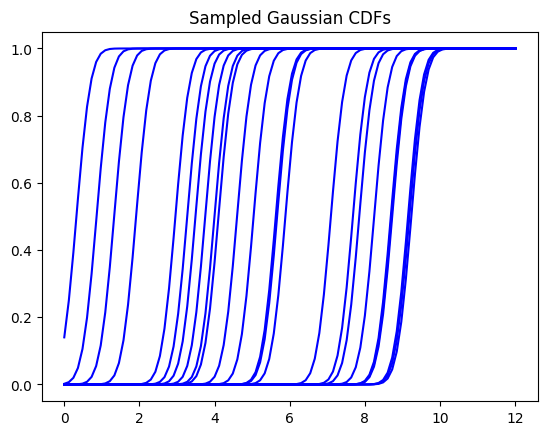

In [8]:
plt.title("Sampled Gaussian CDFs")
plt.plot(np.linspace(0, 12, num=100), posterior_predictive.cdf(np.stack([np.linspace(0, 12, num=100) for _ in range(y.size)], axis=1))[:, :25], c='blue')
plt.show()

(0.0, 1.0)

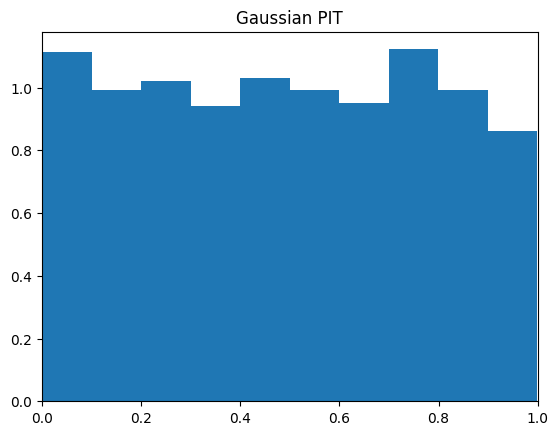

In [9]:
plt.title("Gaussian PIT")
plt.hist(posterior_predictive.cdf(y.flatten()), density=True)
plt.xlim(0, 1)

/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_65357/768121519.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_65357/1057251793.py:16: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


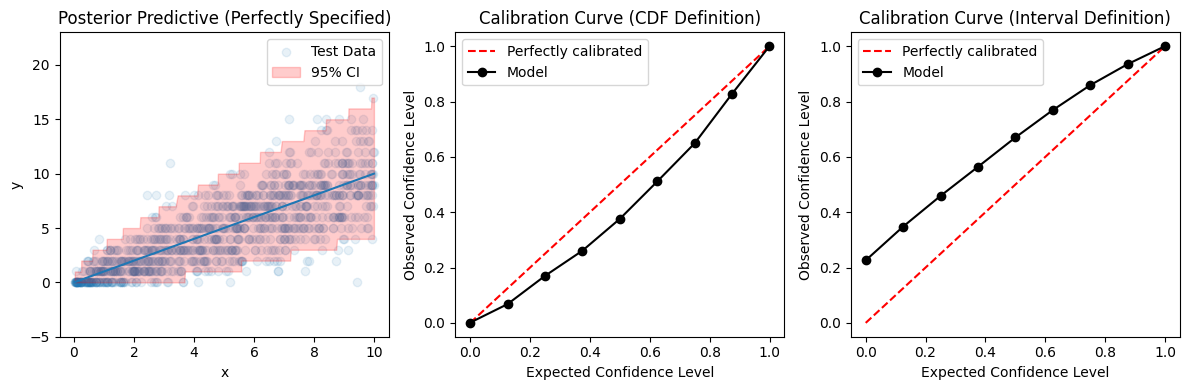

In [10]:
x = np.random.uniform(1e-4, 10, size=1000)
y = poisson.rvs(mu=x)

# Perfectly specified model.
lambda_hat = x
posterior_predictive = poisson(mu=lambda_hat)
preds = np.floor(lambda_hat)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_posterior_predictive(x, y, lambda_hat, *posterior_predictive.ppf([[0.025], [0.975]]), ax=axs[0], show=False)
axs[0].set_title("Posterior Predictive (Perfectly Specified)")
plot_regression_calibration_curve_cdf(y, posterior_predictive, ax=axs[1], show=False)
axs[1].set_title("Calibration Curve (CDF Definition)")
plot_regression_calibration_curve_interval(y, posterior_predictive, ax=axs[2], show=False)
axs[2].set_title("Calibration Curve (Interval Definition)")
fig.tight_layout()
plt.show()

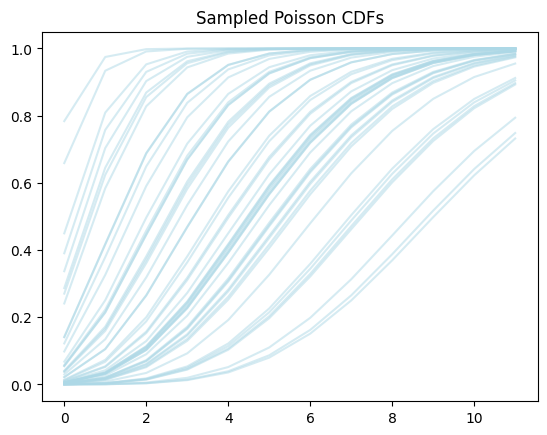

In [11]:
plt.title("Sampled Poisson CDFs")
plt.plot(np.arange(12), posterior_predictive.cdf(np.stack([np.arange(12) for _ in range(y.size)], axis=1))[:, :50], c='lightblue', alpha=0.5)
plt.show()

(0.0, 1.0)

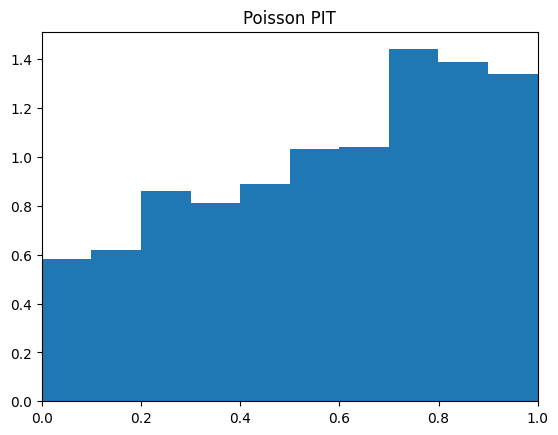

In [12]:
plt.title("Poisson PIT")
plt.hist(posterior_predictive.cdf(y.flatten()), density=True)
plt.xlim(0, 1)

In [14]:
conf

array([0.12654454, 0.12972558, 0.13157234, 0.13392784, 0.13792617,
       0.13952714, 0.14347425, 0.14721844, 0.14888076, 0.15219655,
       0.15651886, 0.15960245, 0.16318595, 0.16948537, 0.17350458,
       0.17672805, 0.18534299, 0.19230248, 0.19668853, 0.21114197,
       0.22146453, 0.23287003, 0.25156931, 0.26593561, 0.28284022,
       0.33249913, 0.36194852, 0.43116469, 0.59777127, 0.86164239])

In [15]:
acc

array([0.20588235, 0.18181818, 0.21212121, 0.20588235, 0.12121212,
       0.21212121, 0.14705882, 0.15151515, 0.03030303, 0.14705882,
       0.20588235, 0.21212121, 0.06060606, 0.17647059, 0.21212121,
       0.15151515, 0.23529412, 0.06060606, 0.21212121, 0.29411765,
       0.23529412, 0.21212121, 0.21212121, 0.23529412, 0.24242424,
       0.3030303 , 0.29411765, 0.36363636, 0.66666667, 0.91176471])

In [40]:
print(compute_discrete_ece(y, preds, posterior_predictive.pmf(preds), alpha=2))

0.0035745163110305024


/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_65357/768121519.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


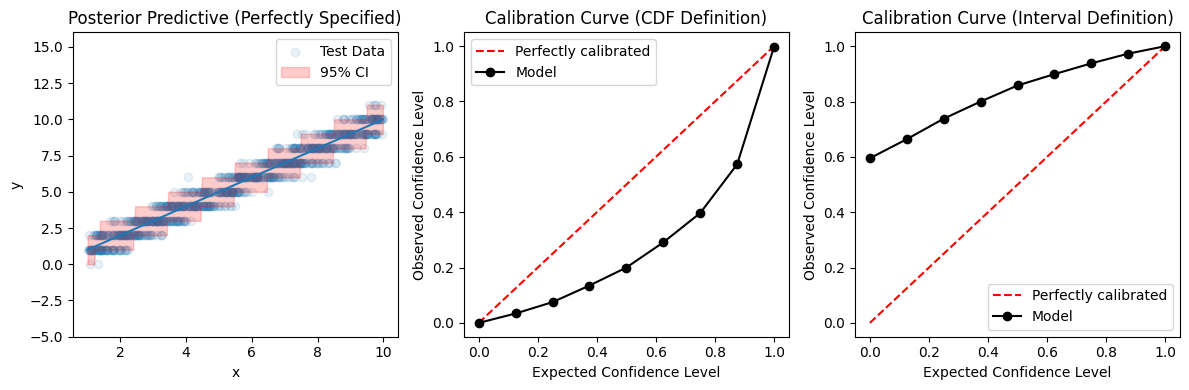

In [54]:
x = np.random.uniform(1, 10, size=1000)
y = np.array([DoublePoisson(x_i, 3*x_i).rvs(1) for x_i in x]).astype(int)

mu_hat = x
phi_hat = 3*x
posterior_predictive = DoublePoisson(mu_hat, phi_hat)
preds = posterior_predictive.pmf_vals.argmax(axis=0)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_posterior_predictive(x, y, mu_hat, posterior_predictive.ppf(0.025), posterior_predictive.ppf(0.975), ax=axs[0], show=False)
axs[0].set_title("Posterior Predictive (Perfectly Specified)")
plot_regression_calibration_curve_cdf(y.flatten(), posterior_predictive, ax=axs[1], show=False)
axs[1].set_title("Calibration Curve (CDF Definition)")
plot_regression_calibration_curve_interval(y.flatten(), posterior_predictive, ax=axs[2], show=False)
axs[2].set_title("Calibration Curve (Interval Definition)")
plt.show()

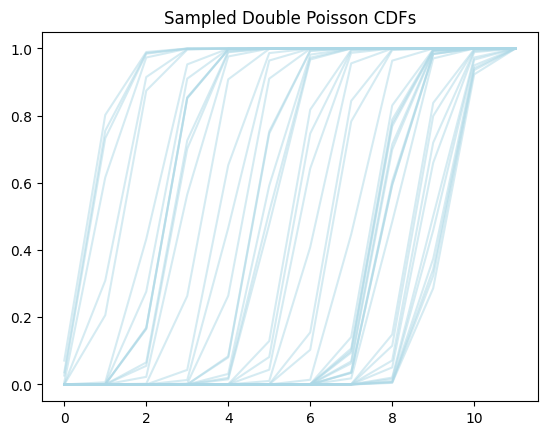

In [55]:
plt.title("Sampled Double Poisson CDFs")
plt.plot(np.arange(12), posterior_predictive.cdf(np.stack([np.arange(12) for _ in range(y.size)], axis=1))[:, :50], c='lightblue', alpha=0.5)
plt.show()

(0.0, 1.0)

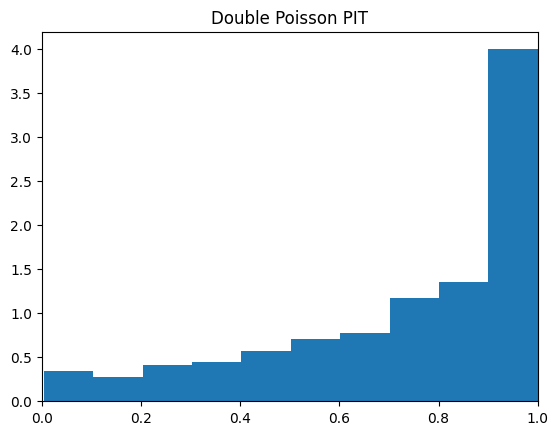

In [56]:
plt.title("Double Poisson PIT")
plt.hist(posterior_predictive.cdf(y.flatten()), density=True)
plt.xlim(0, 1)

In [50]:
print(compute_discrete_ece(y.flatten(), preds, posterior_predictive.pmf(preds), alpha=2))

0.006892110700116499


/var/folders/kl/g95z0vyx56g1ss60x5mm3l9m0000gn/T/ipykernel_65357/768121519.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


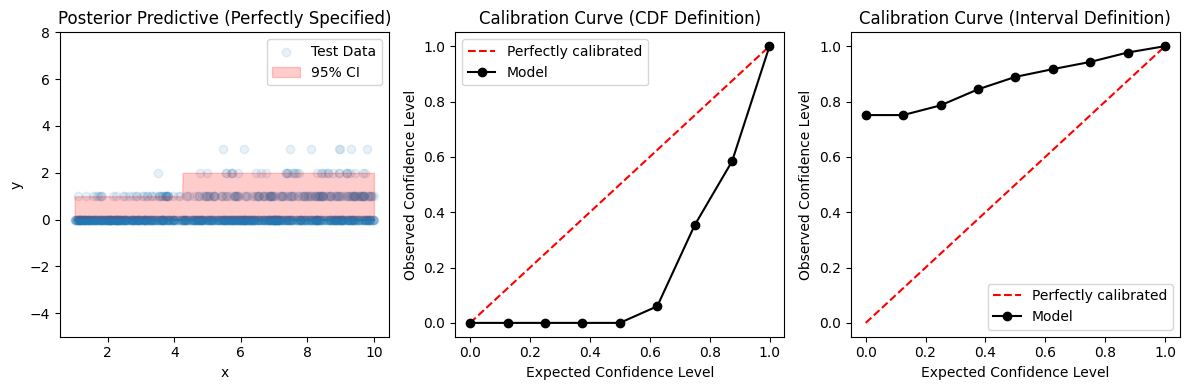

In [59]:
x = np.random.uniform(1, 10, size=1000)
y = nbinom.rvs(n=x, p=0.95)

n_hat = x
p_hat = 0.95
posterior_predictive = nbinom(n=n_hat, p=p_hat)
preds = np.floor((n_hat - 1) * (1 - p_hat) / p_hat)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plot_posterior_predictive(x, y, preds, posterior_predictive.ppf(0.025), posterior_predictive.ppf(0.975), ax=axs[0], show=False)
axs[0].set_title("Posterior Predictive (Perfectly Specified)")
plot_regression_calibration_curve_cdf(y, posterior_predictive, ax=axs[1], show=False)
axs[1].set_title("Calibration Curve (CDF Definition)")
plot_regression_calibration_curve_interval(y, posterior_predictive, ax=axs[2], show=False)
axs[2].set_title("Calibration Curve (Interval Definition)")
plt.show()

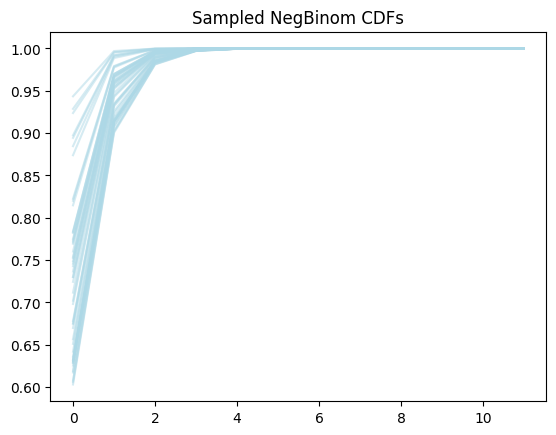

In [60]:
plt.title("Sampled NegBinom CDFs")
plt.plot(np.arange(12), posterior_predictive.cdf(np.stack([np.arange(12) for _ in range(y.size)], axis=1))[:, :50], c='lightblue', alpha=0.5)
plt.show()

(0.0, 1.0)

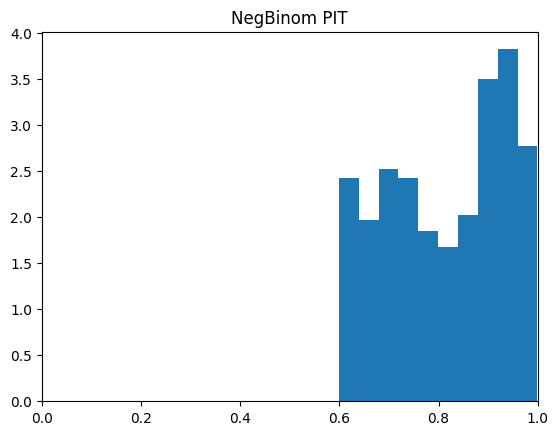

In [61]:
plt.title("NegBinom PIT")
plt.hist(posterior_predictive.cdf(y.flatten()), density=True)
plt.xlim(0, 1)

In [63]:
print(compute_discrete_ece(y.flatten(), preds, posterior_predictive.pmf(preds), alpha=2))

0.006797045275855211
